## Imports

In [1]:
import re
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from datetime import datetime, timezone
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer


nltk.download("rslp")


[nltk_data] Downloading package rslp to /home/marvin-
[nltk_data]     linux/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

## Funções utilizadas durante a análise

In [2]:
def stemming(texto: str) -> str:
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    palavras = [stemmer.stem(palavra) for palavra in texto.split()]
    return " ".join(palavras)


def remover_stop_words(texto: str, stop_words: list) -> str:
    stopwords = nltk.corpus.stopwords.words("portuguese")
    stopwords.extend(stop_words)
    texto = " ".join(list(filter(lambda x: x not in stopwords, texto.split())))
    return texto


def formatar_texto(texto: str) -> str:
    texto = (
        re.sub(r"(http\S+)|(@\w+)", "", texto)  # remove links, usuários #
        .replace(".", "")
        .replace(";", "")
        .replace("—", "")
    )

    texto = re.sub(r"(  +)", " ", texto)  # remove espaços duplos
    texto = texto.lower().strip()

    return texto


def datetime_to_period(hour):
    if hour >= 0 and hour < 6:
        return "overnight"
    elif hour >= 6 and hour < 12:
        return "morning"
    elif hour >= 12 and hour < 18:
        return "afternoon"
    elif hour >= 18 and hour < 24:
        return "night"


def datetime_to_hour(temp_str: str) -> int:
    datetime_object = datetime.strptime(temp_str, "%a %b %d %H:%M:%S %z %Y")
    return (
        datetime_object.replace(tzinfo=timezone.utc).astimezone(tz=None).hour
    )  # retorna a hora em formato inteiro ajustado para o fuso horário do Brasil


def get_top_ngram(corpus, gram_size=None, top_gram=10):
    vec = CountVectorizer(ngram_range=(gram_size, gram_size)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_gram]


## Carregando dataset e dropando colunas não necessárias.

In [3]:
df = pd.read_csv("../data/raw/NoThemeTweets.csv").drop(
    columns=["id", "query_used"], axis=1  # remove colunas desnecessárias
)

df.sample(30)


,tweet_text,tweet_date,sentiment
756580,Mando dm? Porque é que eu me haveria de revela...,Wed Oct 03 06:29:17 +0000 2018,Positivo
763492,"Então, mamãe apoia um candidato que é a favor ...",Sat Oct 06 04:10:30 +0000 2018,Positivo
754845,@_fuzzypickles o haddad cresceu demais n adian...,Tue Oct 02 00:23:12 +0000 2018,Negativo
577830,@insanitykai Sim...Nem mesmo com CEG esses álb...,Thu Sep 20 00:41:18 +0000 2018,Negativo
425819,@haylizinha o pior de tudo é a galera alimenta...,Wed Sep 12 16:54:56 +0000 2018,Negativo
391906,Queria estar assim :( https://t.co/okdXYJO4X4,Sun Sep 09 23:34:40 +0000 2018,Negativo
667259,@159FXL Você é um bebê. :(,Mon Sep 24 21:49:44 +0000 2018,Negativo
364516,queria brigadeiro mas nao posso gastar o dinhe...,Sun Sep 09 16:04:20 +0000 2018,Negativo
714334,@marujaencerrada @MariettaPeluda @Fumatron_N Í...,Thu Sep 27 23:15:24 +0000 2018,Positivo
80124,tô chorando muito com os sétimos :(,Tue Aug 21 00:32:28 +0000 2018,Negativo


## Removendo links e referência a usuários e algumas pontuações..

In [4]:
df.drop_duplicates(["tweet_text"], inplace=True)  # remove textos duplicados
df["tweet_text"] = df["tweet_text"].apply(
    lambda tweet: formatar_texto(texto=tweet)
)  # formata texto do dataframe

df.loc[350538, "tweet_text"]


'isto foi tão à toa, fds :((( ❤'

## Gerando novos dados utilizando o dataframe.

In [5]:
df = df.assign(
    number_words=df.tweet_text.apply(lambda x: len(x.split(" "))),
)  # adiciona coluna com número de palavras

df = df.assign(
    avg_word_length=df.tweet_text.str.split()
    .apply(lambda x: [len(i) for i in x])
    .map(lambda x: np.mean(x))
)  # adiciona coluna com média de caracteres por palavra no tweet

formated_df = df.drop(
    df[df.number_words < 5].index
)  # remove tweets com menos de 5 palavras

formated_df


,tweet_text,tweet_date,sentiment,number_words,avg_word_length
0,14 para eu ir :),Tue Aug 21 04:35:39 +0000 2018,Positivo,5,2.400000
1,o meu like eu já dei na época :),Tue Aug 21 04:32:55 +0000 2018,Positivo,9,2.666667
2,eu só queria conseguir comer alguma coisa pra ...,Tue Aug 21 04:32:37 +0000 2018,Positivo,11,4.636364
3,:d que lindo dia !,Tue Aug 21 04:32:33 +0000 2018,Positivo,5,2.800000
4,"pq da pr jeito!!é uma ""oferta"", ha q aproveita...",Tue Aug 21 04:32:21 +0000 2018,Positivo,10,4.100000
...,...,...,...,...,...
785809,acordar 8 horas é tão bom :),Fri Oct 12 11:10:01 +0000 2018,Positivo,7,3.142857
785810,"olá, mayck você já é cliente claro? caso não s...",Fri Oct 12 11:16:02 +0000 2018,Positivo,29,3.931034
785811,opa tava na merda mm e fiquei logo mais feliz ...,Fri Oct 12 11:12:49 +0000 2018,Positivo,15,3.666667
785812,foi como a tua lealdade :),Fri Oct 12 11:11:24 +0000 2018,Positivo,6,3.500000


## Informações sombre o dataframe.

In [6]:
print(df.shape)
print(formated_df.describe())

formated_df.sample(5)


(776753, 5)
        number_words  avg_word_length
count  645314.000000    645314.000000
mean       14.496905         4.049946
std         9.941685         0.731306
min         5.000000         1.000000
25%         7.000000         3.600000
50%        11.000000         4.000000
75%        18.000000         4.428571
max        85.000000        55.200000


,tweet_text,tweet_date,sentiment,number_words,avg_word_length
553325,sdd do melhor dia da minha vida bicho :(,Wed Sep 19 00:02:29 +0000 2018,Negativo,9,3.555556
725847,sinto uma necessidade enorme de tentar fazer t...,Sun Sep 30 02:12:59 +0000 2018,Negativo,24,4.458333
763949,pessoas que eu não conheço por favor não manda...,Sat Oct 06 03:21:55 +0000 2018,Positivo,22,4.090909
446059,mano te amo demais sério você melhorou 100% me...,Thu Sep 13 00:16:11 +0000 2018,Negativo,11,4.000000
41868,vão ver o livestream do meu puto marcelão ajud...,Fri Aug 17 21:37:17 +0000 2018,Positivo,26,4.115385


## Número de tweets com label negativa e positiva.

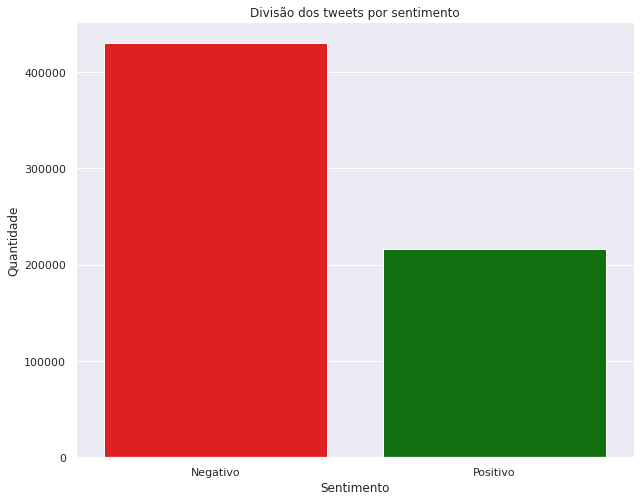

In [7]:
sentiments = formated_df["sentiment"].value_counts()
sns.set(rc={"figure.figsize": (10, 8)})
sns.barplot(
    x=sentiments.index,
    y=sentiments.values,
    palette={"Positivo": "green", "Negativo": "red"},
)
plt.xlabel("Sentimento")
plt.ylabel("Quantidade")
plt.title("Divisão dos tweets por sentimento")

plt.show()


## Histograma da quantidade de palavras nos tweets.
#### Nota-se claramente uma tendência dos tweets serem textos curtos, majoritariamente com menos de 20 palavras.

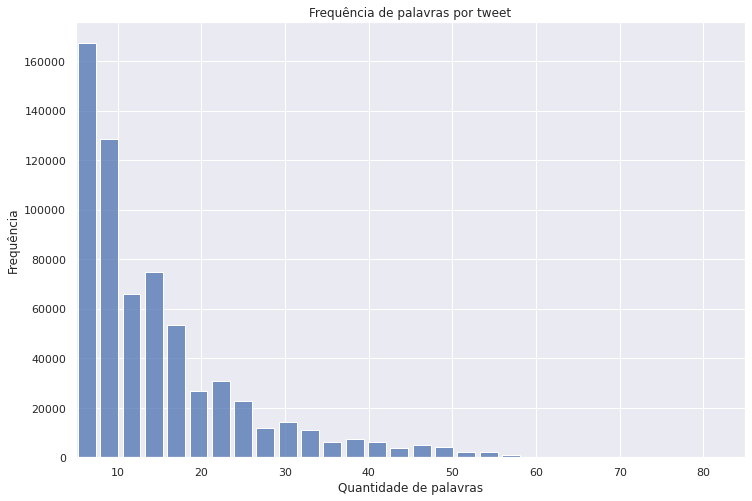

In [8]:
sns.set(rc={"figure.figsize": (12, 8)})
sns.histplot(data=formated_df, x="number_words", bins=30, shrink=0.8)

plt.xlabel("Quantidade de palavras")
plt.ylabel("Frequência")
plt.title("Frequência de palavras por tweet")
plt.xlim(formated_df.number_words.min(), formated_df.number_words.max())
plt.show()


## Histograma da quantidade de palavras nos tweets separados por sentimentos.
#### Nota-se claramente uma tendência dos tweets negativos serem mais curtos, contudo no dataset a uma maior quantidade de tweets negativos, praticamente o dobro isso deve ser considerado. Logo, a tendência seria que  os tweets negativos fossem cerca duas vezes em quantidade, contudo os tweets menores são ligeiramente maiores que o dobro, logo a uma leve tendência de tweets menores serem mais negativos.

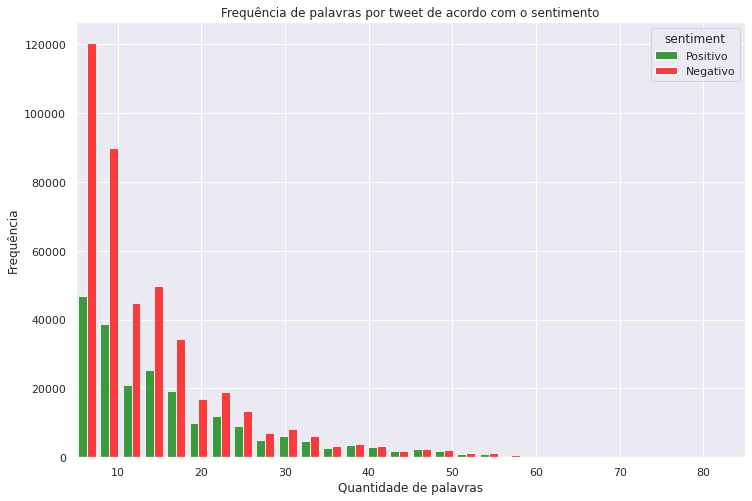

In [9]:
sns.set(rc={"figure.figsize": (12, 8)})
sns.histplot(
    data=formated_df,
    x="number_words",
    hue="sentiment",
    bins=30,
    palette={"Positivo": "green", "Negativo": "red"},
    multiple="dodge",
    shrink=0.8,
)
plt.xlabel("Quantidade de palavras")
plt.ylabel("Frequência")
plt.title("Frequência de palavras por tweet de acordo com o sentimento")
plt.xlim(formated_df.number_words.min(), formated_df.number_words.max())
plt.show()


## Tamanho médio das palavras em cada tweet

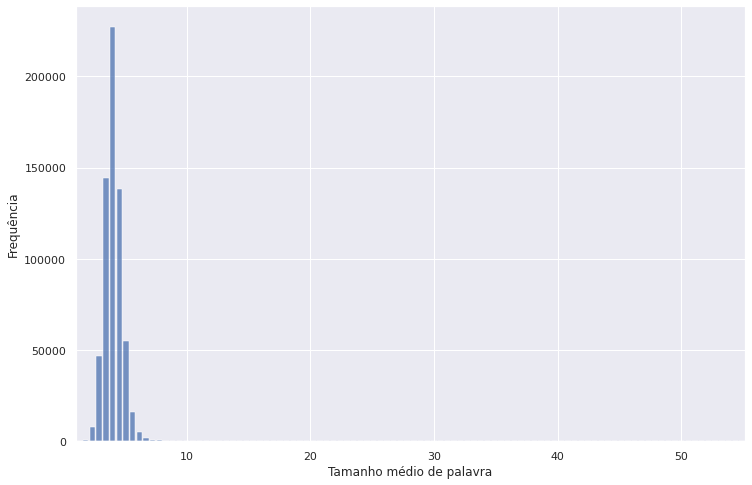

In [10]:
sns.set(rc={"figure.figsize": (12, 8)})

sns.histplot(data=formated_df, x="avg_word_length", bins=100, shrink=0.8)
plt.xlabel("Tamanho médio de palavra")
plt.ylabel("Frequência")
plt.xlim(formated_df["avg_word_length"].min(), formated_df["avg_word_length"].max())
plt.show()


## Separação dos dataframes em positivo e negativo e criação do corpus

In [11]:
df_positivo = formated_df.query("sentiment == 'Positivo'")
df_negativo = formated_df.query("sentiment == 'Negativo'")
df_all = formated_df

positive_text = " ".join(df_positivo.tweet_text)
negative_text = " ".join(df_negativo.tweet_text)
all_text = " ".join(df_all.tweet_text)


## Geração do período do dia do tweet

In [12]:
formated_df = formated_df.assign(
    day_period=formated_df.tweet_date.apply(
        lambda x: datetime_to_period(datetime_to_hour(x))
    )
)

formated_df


,tweet_text,tweet_date,sentiment,number_words,avg_word_length,day_period
0,14 para eu ir :),Tue Aug 21 04:35:39 +0000 2018,Positivo,5,2.400000,overnight
1,o meu like eu já dei na época :),Tue Aug 21 04:32:55 +0000 2018,Positivo,9,2.666667,overnight
2,eu só queria conseguir comer alguma coisa pra ...,Tue Aug 21 04:32:37 +0000 2018,Positivo,11,4.636364,overnight
3,:d que lindo dia !,Tue Aug 21 04:32:33 +0000 2018,Positivo,5,2.800000,overnight
4,"pq da pr jeito!!é uma ""oferta"", ha q aproveita...",Tue Aug 21 04:32:21 +0000 2018,Positivo,10,4.100000,overnight
...,...,...,...,...,...,...
785809,acordar 8 horas é tão bom :),Fri Oct 12 11:10:01 +0000 2018,Positivo,7,3.142857,morning
785810,"olá, mayck você já é cliente claro? caso não s...",Fri Oct 12 11:16:02 +0000 2018,Positivo,29,3.931034,morning
785811,opa tava na merda mm e fiquei logo mais feliz ...,Fri Oct 12 11:12:49 +0000 2018,Positivo,15,3.666667,morning
785812,foi como a tua lealdade :),Fri Oct 12 11:11:24 +0000 2018,Positivo,6,3.500000,morning


## Quantidade de tweets por período do dia.

#### Nota-se claramente que há uma maior quantidade de tweets de noite, provavelmente nos outros horários as pessoas estão ou trabalhando, estudando ou dormindo.

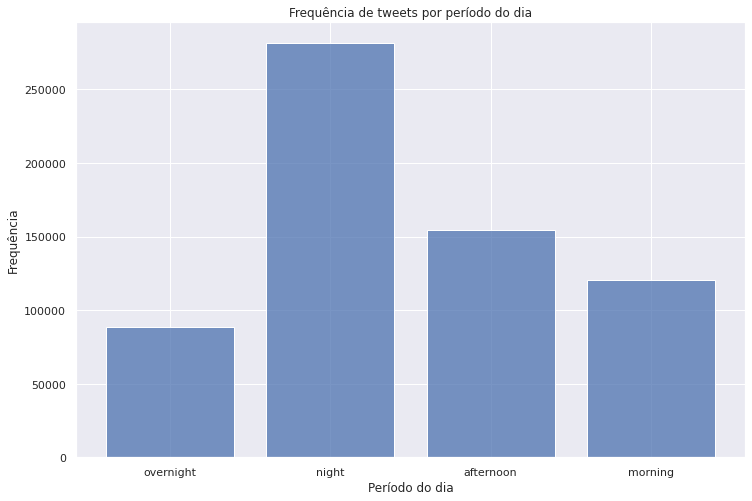

In [13]:
sns.histplot(data=formated_df, x="day_period", bins=5, shrink=0.8)
plt.xlabel("Período do dia")
plt.ylabel("Frequência")
plt.title("Frequência de tweets por período do dia")
plt.show()


## Quantidade de tweets por período do dia separado por sentimento.

#### Analogamente a quantidade a tendência é ter cerca de o dobro de tweets negativos do que positivos. Contudo, em períodos como noite e madrugada a proporção de tweets negativos é bem maior do que a esperada.

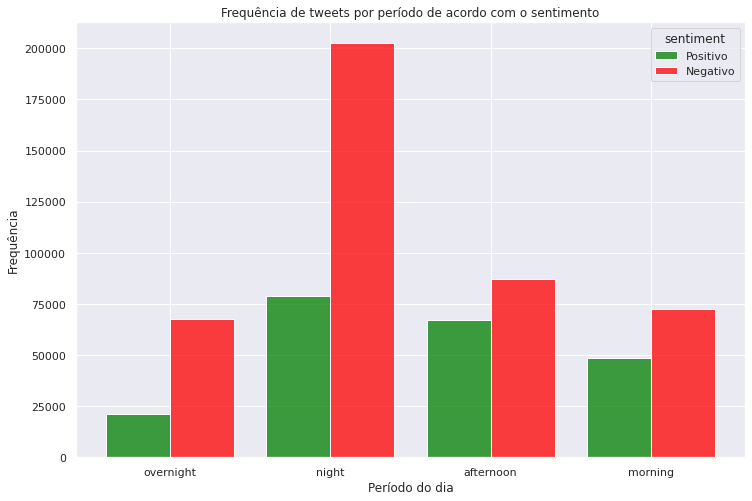

In [14]:
sns.histplot(
    data=formated_df,
    x="day_period",
    hue="sentiment",
    bins=5,
    palette={"Positivo": "green", "Negativo": "red"},
    multiple="dodge",
    shrink=0.8,
)
plt.xlabel("Período do dia")
plt.ylabel("Frequência")
plt.title("Frequência de tweets por período de acordo com o sentimento")
plt.show()


## Cria os top 50 stop words que mais aparecem no corpus

analyzed stopwords:
 ['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivesse

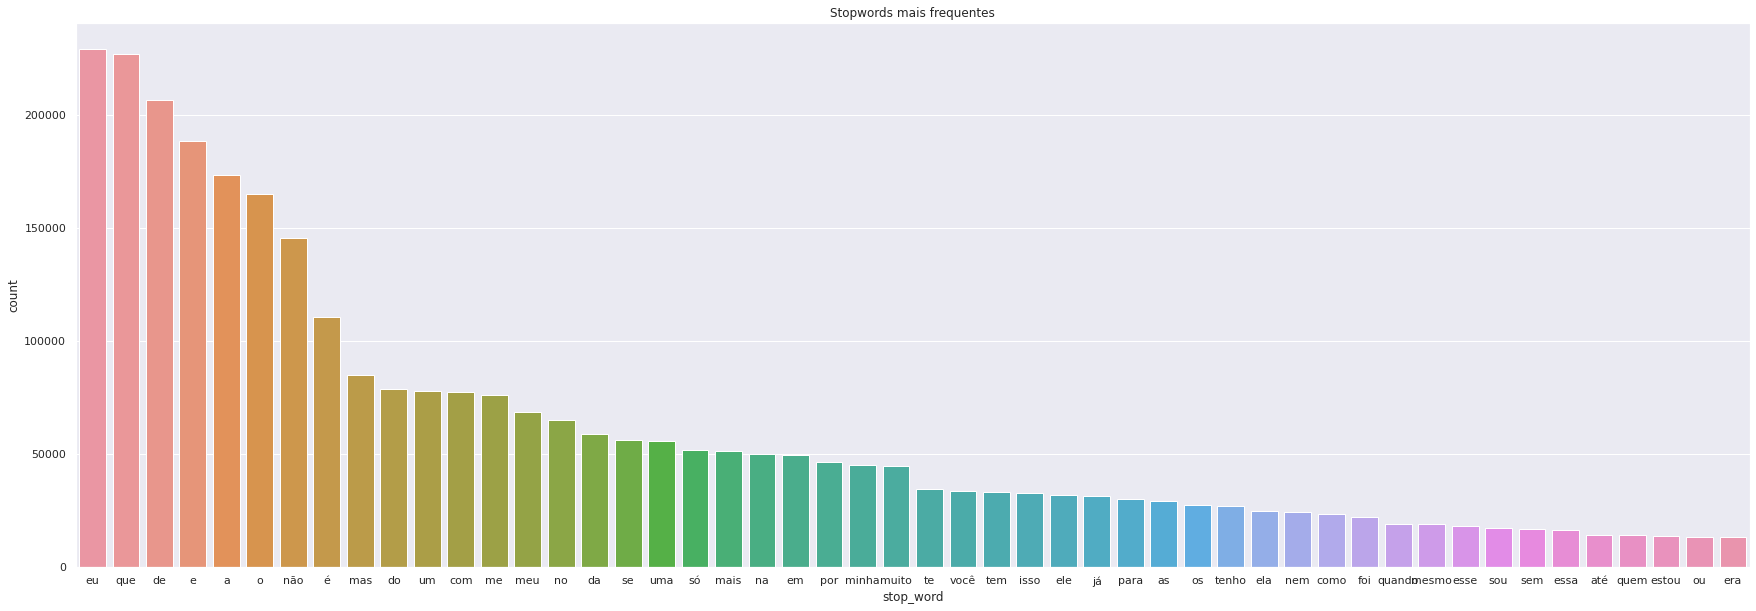

In [16]:
from collections import defaultdict

dic = defaultdict(int)

stopwords = nltk.corpus.stopwords.words("portuguese")

print("analyzed stopwords:\n", stopwords)


for word in (all_text).split():
    if word in stopwords:
        dic[word] += 1


top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:50]  # top 50 stopwords


stopwords_df = pd.DataFrame(top, columns=["stop_word", "count"])


sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="stop_word", y="count", data=stopwords_df)
plt.title("Stopwords mais frequentes")
plt.show()


## O nltk considera como stop words algumas palavras que podem conter cunho sentimental, por conta disso essas palavras serão removidas desse vetor.

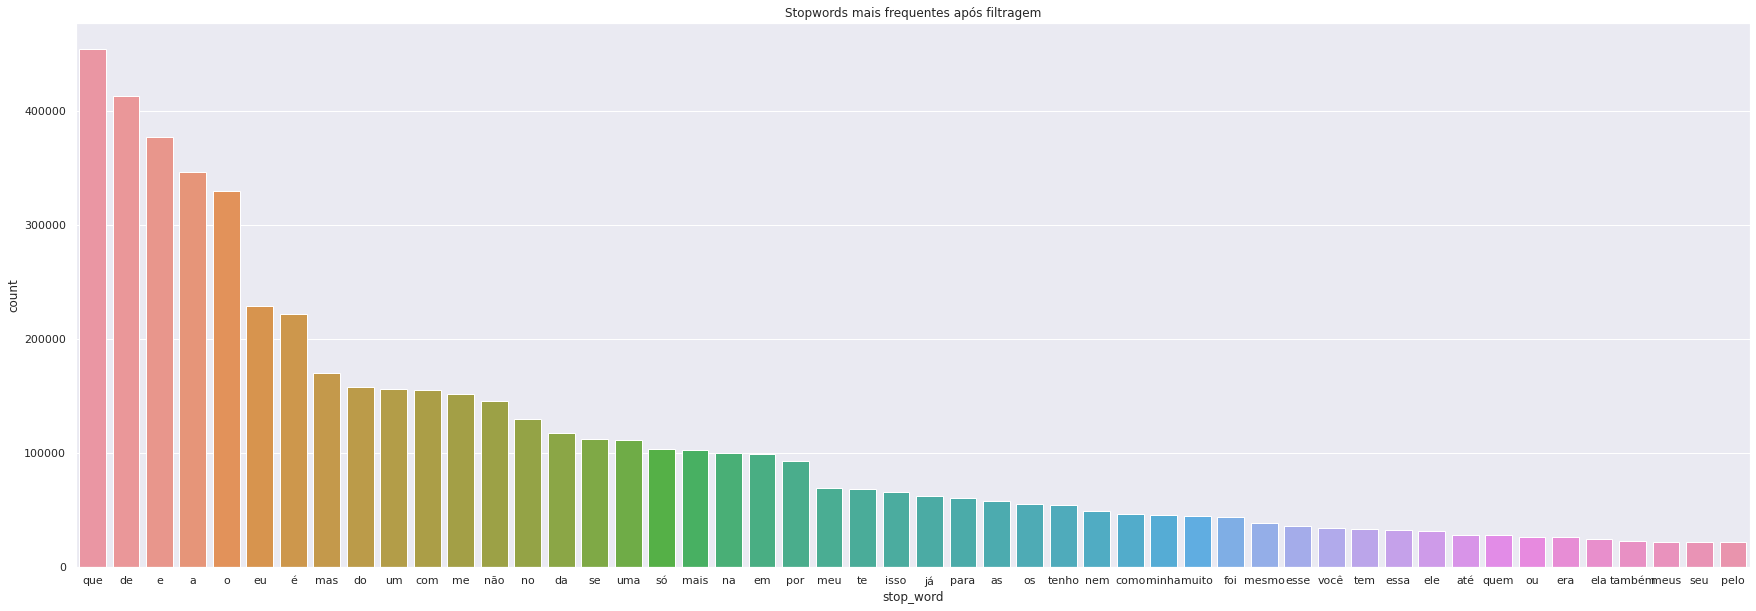

In [17]:
relevant_stop_words = [
    "eu",
    "não",
    "meu",
    "minha",
    "muito",
    "você",
    "tem",
    "ele",
    "ela",
    "quando",
    "sou",
    "você",
    "sem",
    "estou",
]  # stopwords consideradas relevantes para análise de sentimento, serão mantinidas em todo o processo de análise
stopwords = list(
    filter(lambda x: x not in relevant_stop_words, stopwords)
)  # remove do conjunto de stopwords palavras que não serão consideradas para filtragem

for word in all_text.split():
    if word in stopwords:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:50]  # top 50 stopwords


stopwords_df = pd.DataFrame(top, columns=["stop_word", "count"])


sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="stop_word", y="count", data=stopwords_df)
plt.title("Stopwords mais frequentes após filtragem")
plt.show()


## Análise as palavras mais frequentes que não são stop words.

#### Nota-se que há várias expressões e abreviações comuns  na internet e na língua portuguesa.

In [18]:
from collections import Counter


counter = Counter(all_text.split())
most = counter.most_common(80)
print(most)
print(len(most))

x, y = [], []
for word, count in most:
    if word not in stopwords:
        x.append(word)
        y.append(count)

most_common_words = list(zip(x, y))

most_common_words_df = pd.DataFrame(
    most_common_words, columns=["word", "count"]
)  # cria um dataframe com as palavras mais frequentes

sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="word", y="count", data=most_common_words_df)
plt.title("Palavras mais frequentes")
plt.show()

[(':(', 349885), ('eu', 229051), ('que', 227046), ('de', 206458), ('e', 188375), ('a', 173204), ('o', 164955), (':)', 147926), ('não', 145389), ('é', 110706), ('mas', 84999), ('do', 78792), ('um', 77857), ('com', 77444), ('pra', 76035), ('me', 75861), ('meu', 68694), ('no', 64818), ('da', 58698), ('se', 56063), ('uma', 55691), ('só', 51582), ('mais', 51346), ('na', 49762), ('q', 49730), ('em', 49494), ('por', 46291), ('minha', 45215), ('muito', 44550), ('queria', 43257), ('to', 39204), ('vou', 38474), ('te', 34210), ('você', 33736), ('tem', 33034), ('isso', 32783), (':((', 31801), ('ele', 31787), ('vai', 31773), ('já', 31217), ('para', 30164), ('vc', 29319), ('as', 29073), ('n', 27928), ('os', 27525), ('ter', 27430), ('tenho', 26901), ('pq', 26414), ('ser', 25997), ('tá', 24852), ('ela', 24778), (':d', 24374), ('dia', 24291), ('nem', 24266), ('bem', 24045), ('triste', 23468), ('como', 23334), ('tão', 22820), ('tô', 22125), ('ver', 21923), ('amo', 21895), ('foi', 21862), ('tudo', 21329)

## Adiciona stopwords com palavras ou símbolos não relevantes para análise, descoberto com os gráficos anteriores.

In [20]:
invalid_terms = [
    ":p",  # indentificava apenas como "p"
    ":d",  # indentificava apenas como "d"
    "(",
    "pra",
    "q",
    "_",
    "((",
    "pq",
    "ai"
]  # palavras inrelevantes para análise de sentimento, ou termos abreviados já contidos em stopwords

stopwords.extend(invalid_terms)

counter = Counter(all_text.split())
most = counter.most_common(80)
print(most)
print(len(most))

x, y = [], []
for word, count in most:
    if word not in stopwords:
        x.append(word)
        y.append(count)


most_common_words_filtered = list(zip(x, y))

most_common_words_filtered_df = pd.DataFrame(
    most_common_words_filtered, columns=["word", "count"]
)

191
200
[(':(', 349885), ('eu', 229051), ('que', 227046), ('de', 206458), ('e', 188375), ('a', 173204), ('o', 164955), (':)', 147926), ('não', 145389), ('é', 110706), ('mas', 84999), ('do', 78792), ('um', 77857), ('com', 77444), ('pra', 76035), ('me', 75861), ('meu', 68694), ('no', 64818), ('da', 58698), ('se', 56063), ('uma', 55691), ('só', 51582), ('mais', 51346), ('na', 49762), ('q', 49730), ('em', 49494), ('por', 46291), ('minha', 45215), ('muito', 44550), ('queria', 43257), ('to', 39204), ('vou', 38474), ('te', 34210), ('você', 33736), ('tem', 33034), ('isso', 32783), (':((', 31801), ('ele', 31787), ('vai', 31773), ('já', 31217), ('para', 30164), ('vc', 29319), ('as', 29073), ('n', 27928), ('os', 27525), ('ter', 27430), ('tenho', 26901), ('pq', 26414), ('ser', 25997), ('tá', 24852), ('ela', 24778), (':d', 24374), ('dia', 24291), ('nem', 24266), ('bem', 24045), ('triste', 23468), ('como', 23334), ('tão', 22820), ('tô', 22125), ('ver', 21923), ('amo', 21895), ('foi', 21862), ('tudo'

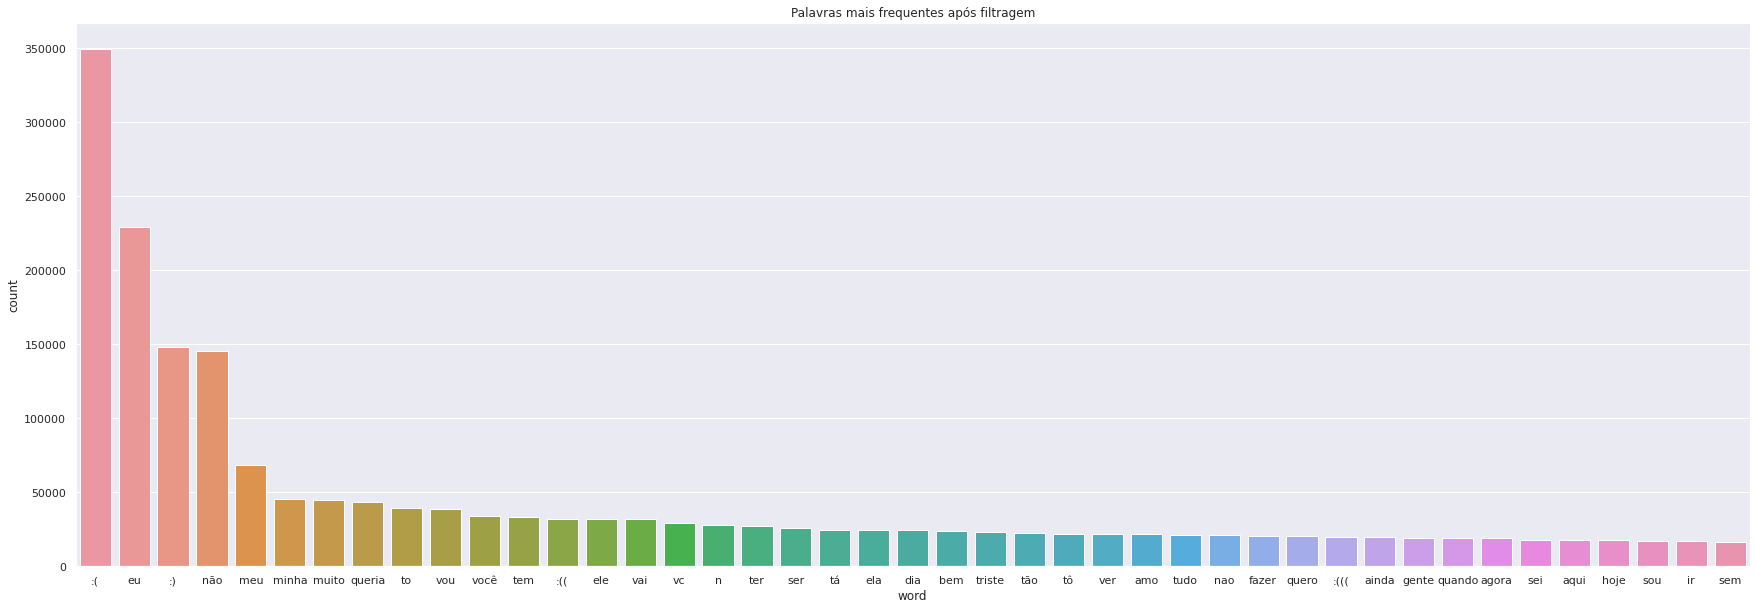

In [21]:
sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="word", y="count", data=most_common_words_filtered_df)
plt.title("Palavras mais frequentes após filtragem")
plt.show()


## Utilizando as análises anteriores é definido um conjunto final de stop words e utilizado para filtra todos os corpus

In [22]:
final_stop_words = stopwords


positive_filter = remover_stop_words(positive_text, final_stop_words)
negative_filter = remover_stop_words(negative_text, final_stop_words)
all_text_filter = remover_stop_words(all_text, final_stop_words)


## Plotagem visual das palavras mais comuns em cada um dos corpus.

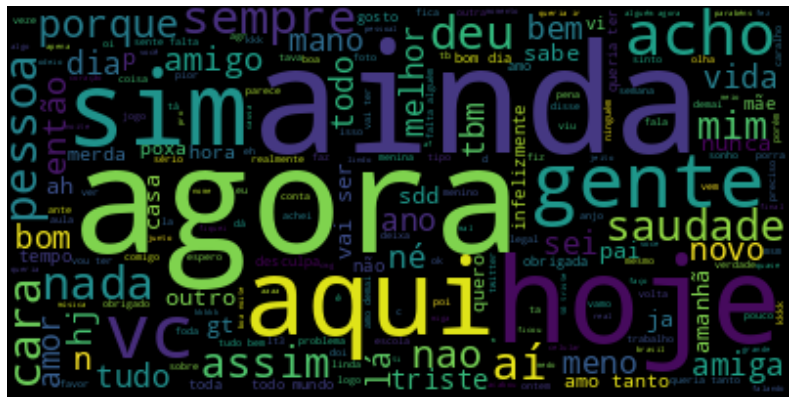

In [23]:
wordcloud = WordCloud().generate(all_text_filter)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


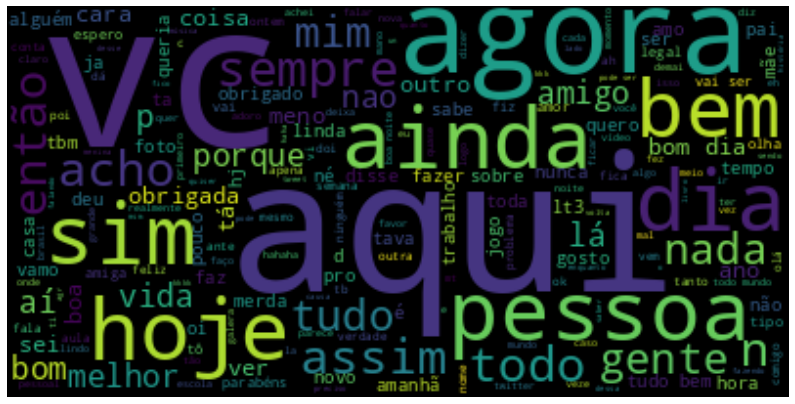

In [24]:
# Generate a word cloud image
wordcloud = WordCloud().generate(positive_filter)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


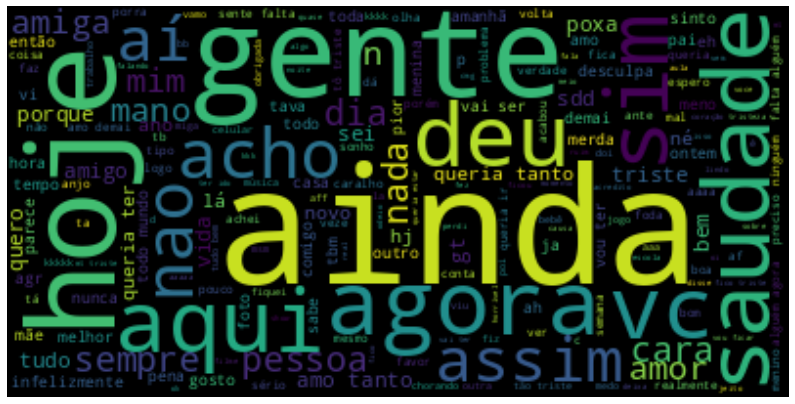

In [25]:
wordcloud = WordCloud().generate(negative_filter)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Plotagem visual dos radicais mais comuns em cada um dos corpus.

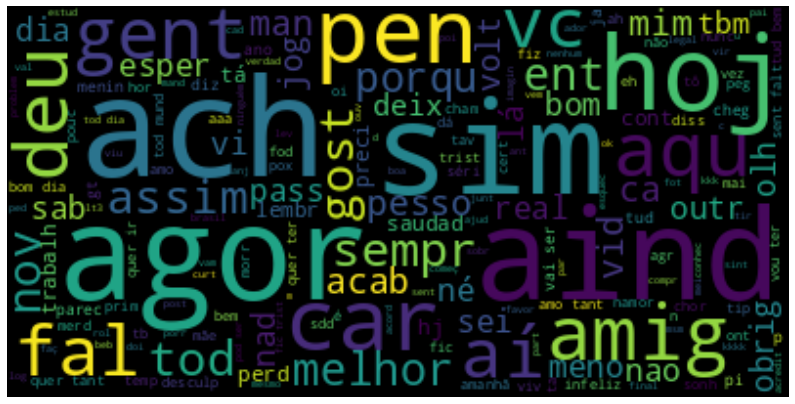

In [26]:
wordcloud = WordCloud().generate(stemming(all_text_filter))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


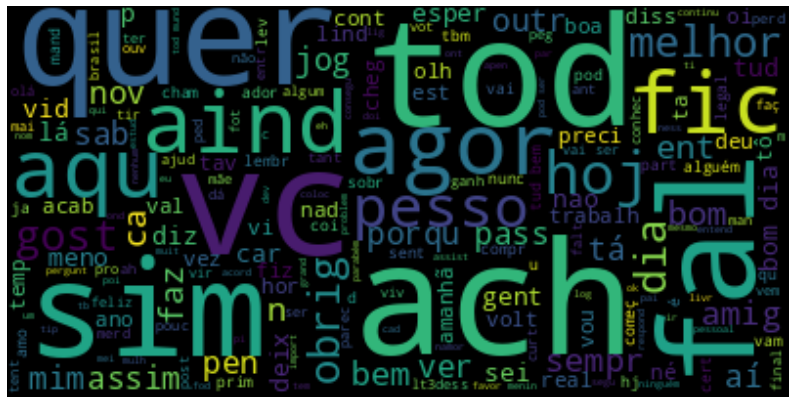

In [27]:
wordcloud = WordCloud().generate(stemming(positive_filter))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


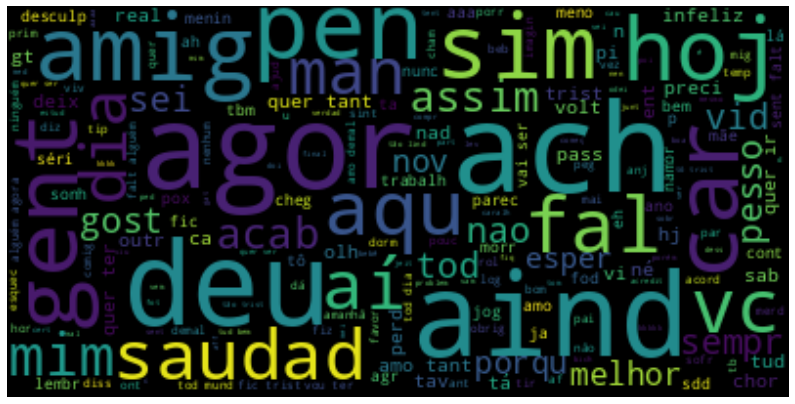

In [28]:
wordcloud = WordCloud().generate(stemming(negative_filter))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Analise dos ngram mais comuns nos corpus.

## Há uma recorrencial de ngrams com termos como "gt", "it","amp" que não consegui identificar o que significam. Além disso há presença de muitas datas de notícias importante que aconteceram na época, e que as pessoas comentaram na época.

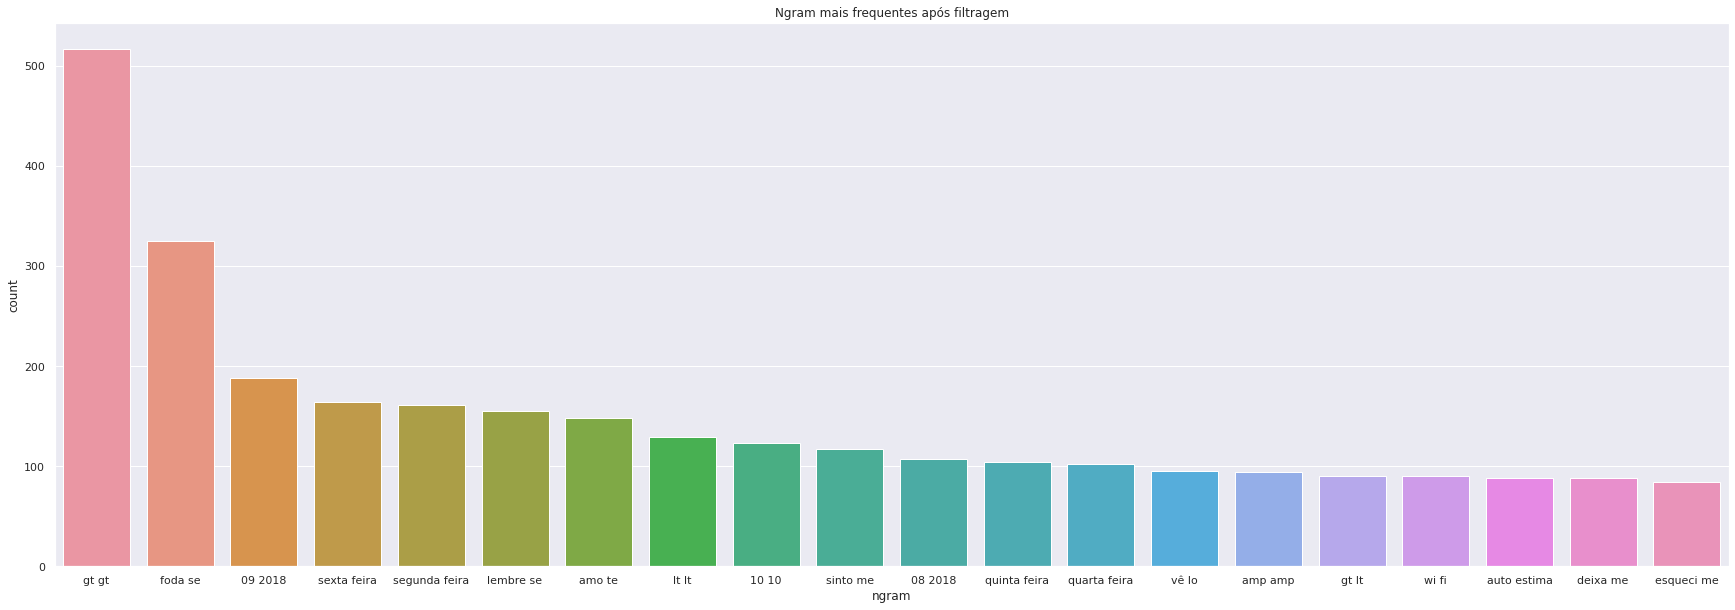

In [29]:
top_2_gram = get_top_ngram(all_text_filter.split(), gram_size=2, top_gram=20 )


top_2_gram_df = pd.DataFrame(top_2_gram, columns=["ngram", "count"])


sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="ngram", y="count", data=top_2_gram_df)
plt.title("Ngram mais frequentes após filtragem")
plt.show()


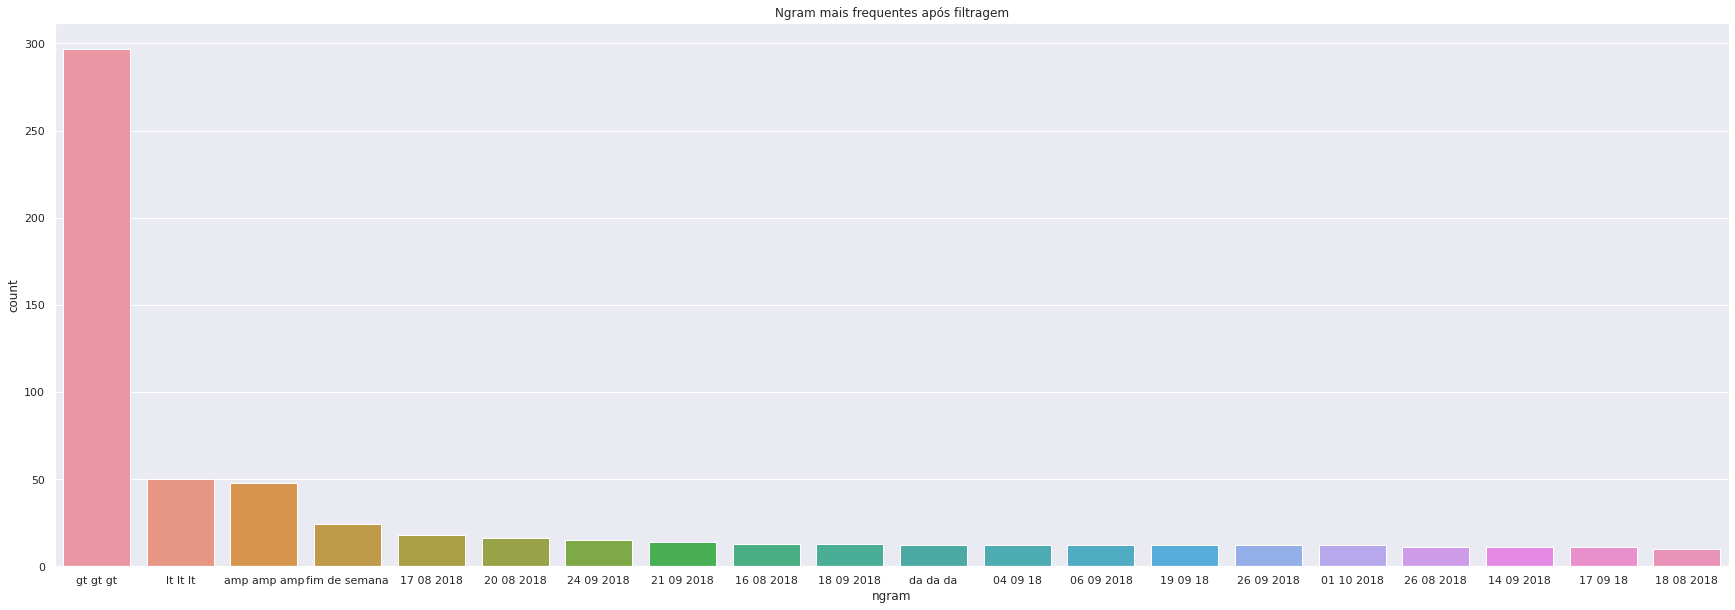

In [30]:
top_3_gram = get_top_ngram(all_text_filter.split(), gram_size=3, top_gram=20)


top_3_gram_df = pd.DataFrame(top_3_gram, columns=["ngram", "count"])


sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="ngram", y="count", data=top_3_gram_df)
plt.title("Ngram mais frequentes após filtragem")
plt.show()


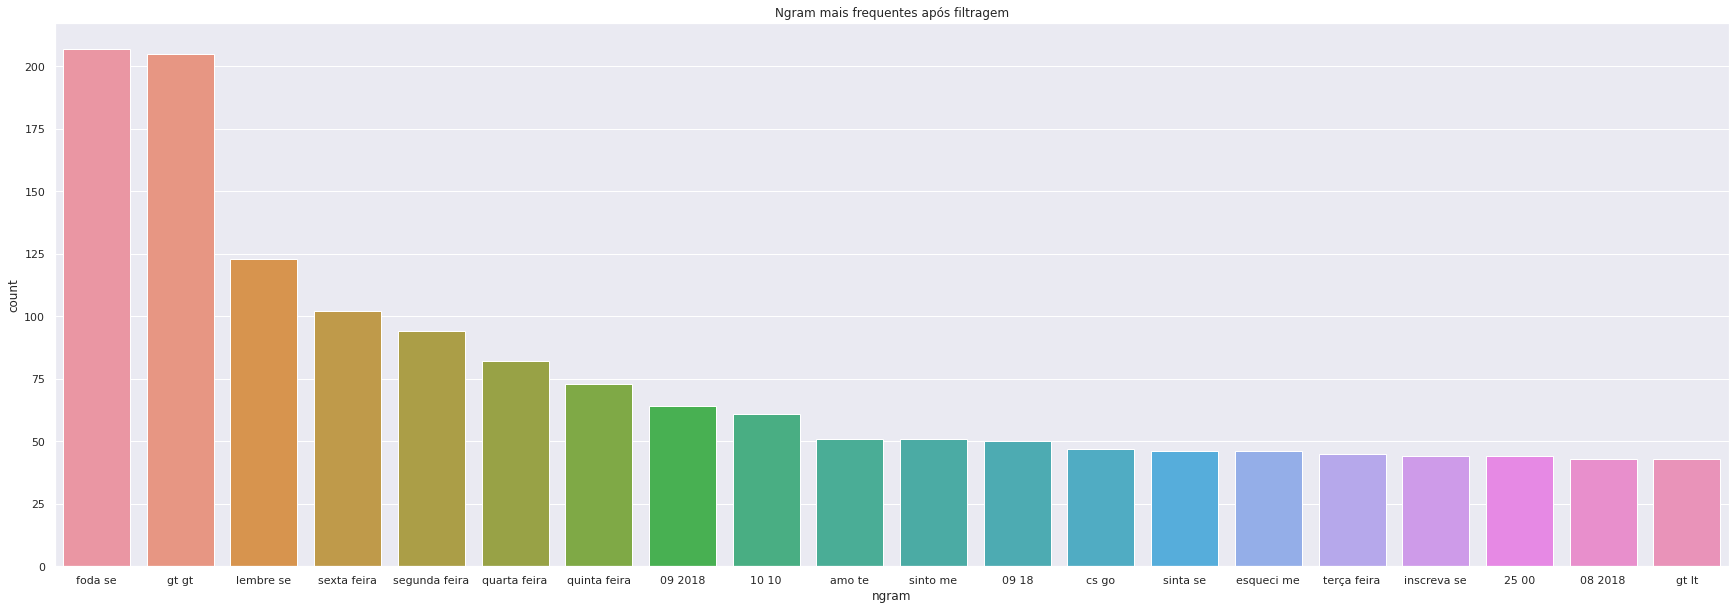

In [31]:
top_2_gram = get_top_ngram(positive_filter.split(), gram_size=2, top_gram=20 )


top_2_gram_df = pd.DataFrame(top_2_gram, columns=["ngram", "count"])


sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="ngram", y="count", data=top_2_gram_df)
plt.title("Ngram mais frequentes após filtragem")
plt.show()

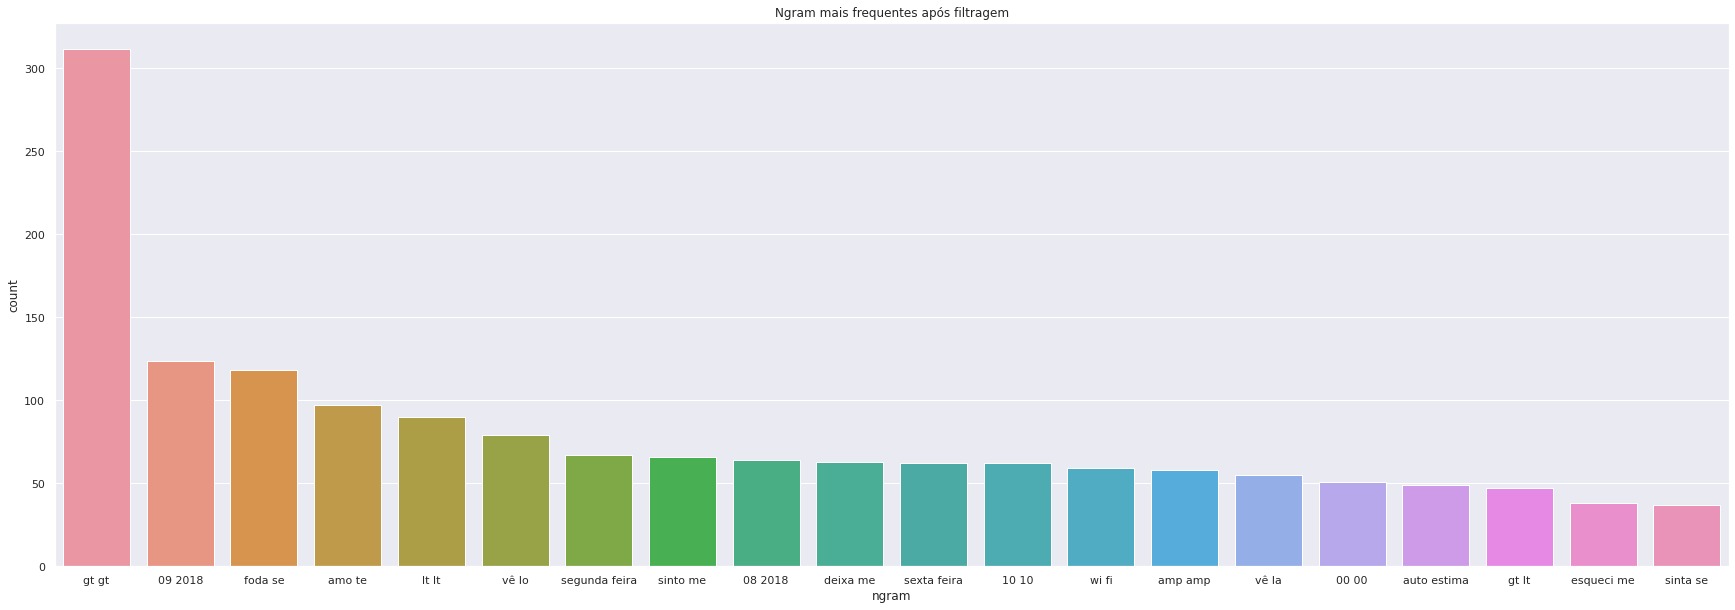

In [32]:
top_2_gram = get_top_ngram(negative_filter.split(), gram_size=2, top_gram=20 )



top_2_gram_df = pd.DataFrame(top_2_gram, columns=["ngram", "count"])


sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="ngram", y="count", data=top_2_gram_df)
plt.title("Ngram mais frequentes após filtragem")
plt.show()